# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Метод k-средних, предобработка признаков


###### <hr\>
**Общая информация**

**Срок сдачи:** 28 ноября 2018, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 28 ноября, -4 балла после 06:00 5 декабря, -6 баллов после 06:00 12 декабря, -8 баллов после 19 декабря

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush

Необходимо в slack создать таск в приватный чат:
/todo Фамилия Имя ссылка на гитхаб @alkhamush
Пример:
/todo Ксения Стройкова https://github.com/stroykova/spheremailru/stroykova_hw1.ipynb @alkhamush
Дополнительно нужно просто скинуть ссылку в slack в личный чат

Используйте данный Ipython Notebook при оформлении домашнего задания.

# Имплементация K-means

Пользуясь наработками выше, имплементируйте метод k-means.  
При инициализации необходимо задавать количество кластеров, функцию расстояния между кластерами (для оригинального k-means - евклидово расстояние) и начальное состояние генератора случайных чисел.

После обучения, среди атрибутов класса `Kmeans` должны появится
* Метки кластеров для объектов
* Координаты центройдов кластеров

k-means - это алгоритм **кластеризации**, а не классификации, а посему метод `.predict()` в нем фактически не нужен, но он может возвращать метки ближайшего кластера для объектов.

###### Задание 1 (2 баллов)
Имплементируйте метод k-means. Задание считается выполненным, если Ваша реализация работает быстрее реализации из sklearn.

Теория для выполнения задания 2 и 3 остаётся на самостоятельное изучение. Теории немного и она совсем простая.

###### Задание 2 (2 балла)
Имплементируйте класс MiniBatchKMeans, который является классом наследником Kmeans.

###### Задание 3 (2 балла)
Превратите k-means в k-means++. Для этого нужно реализовать метод в классе Kmeans, который будет инициализировать более "хорошие" значения центроидов. Чтобы использовался метод k-means++, в параметр init необходимо передать строковое значение 'k-means' (по умолчанию 'random').

###### Задание 4 (2 балла)
В пункте "Проверка корректности метода" нужно нарисовать графики, которые показывают зависимость времени выполнения алгоритма от количества сэмплов. Графики должны быть  нарисованы для различных комбинаций реализаций алгоритма (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). График достаточно построить на 5-10 точках.

###### Задание 5 (2 балла)
В пункте "Применение K-means на реальных данных" нужно сравнить различные реализации k-means (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). После чего написать вывод, в котором должно быть объяснение того, почему один алгоритм оказался лучше остальных или почему не было выявлено лучшего алгоритма.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw4.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл
<hr\>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.metrics import pairwise_distances

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14,5)

%load_ext pycodestyle_magic

The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


In [3]:
# %%pycodestyle


class MyKmeans:
    def __init__(self, k=2, metric='euclidean', max_iter=1000,
                 random_state=None, init='random'):
        """
        Инициализация метода
        :k - количество кластеров
        :metric - функция расстояния между объектами
        :max_iter - максиальное количество итераций
        :random_state - seed для инициализации генератора случайных чисел
        """
        self.k = k
        self.random_state = random_state
        self.max_iter = max_iter
        self.init = init
        self.metric = metric

    def get_metric(self, X, y):
        x_sq = (X ** 2).sum(axis=1)
        y_sq = (y ** 2).sum(axis=1)
        dot_xy = X.dot(y.T)
        return (y_sq + x_sq.reshape(-1, 1) - 2 * dot_xy) ** 0.5

    def init_centroids(self, X):
        if self.init == 'random':
            self.centroids = X[np.random.choice(X.shape[0], size=self.k)]
        elif self.init == 'k-means':
            self.centroids[0] = X[np.random.choice(len(X))]
            for i in range(1, self.k):
                dists = self.get_metric(X, self.centroids[:i]).min(axis=1)
                probabilities = dists / dists.sum()
                self.centroids[i] = X[np.random.choice(len(X),
                                                       p=probabilities)]
        else:
            raise Exception('Unrecognized init')

    def set_labels(self, y):
        new_labels = np.empty((len(self.labels)))
        for i in range(self.k):
            bn = np.bincount(y[self.labels == i])
            if len(bn) > 0:
                new_labels[self.labels == i] = bn.argmax()
        self.labels = new_labels

    def fit(self, X, y=None):
        """
        Процедура обучения k-means
        """

        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)

        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.empty(X.shape[0])

        # Массив с центройдами кластеров
        self.centroids = np.empty((self.k, X.shape[1]))

        # Инициализируем центроиды
        self.init_centroids(X)
        old_centroids = self.centroids.copy()

        for _ in range(self.max_iter):
            # Обновляем метки
            metrics = self.get_metric(X, self.centroids)
            self.labels = metrics.argmin(axis=1)

            # Обновляем центроиды
            for i in range(self.k):
                mask = self.labels == i
                if mask.any():
                    self.centroids[i] = X[mask].mean(axis=0)

            # Если положение центроид не изменилось, выходим
            if np.linalg.norm(old_centroids - self.centroids) < 0.5:
                break
            old_centroids = self.centroids.copy()

        # Присваиваем кластерам метки
        if y is not None:
            self.set_labels(y)
        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания кластера
        Возвращает метку ближайшего кластера для каждого объекта
        """
        return self.get_metric(X, self.centroids).argmin(axis=1)


class MiniBatchKMeans(MyKmeans):
    def __init__(self, k=2, metric='euclidean', max_iter=1000,
                 random_state=None, init='random', batch_size=64):
        super(MiniBatchKMeans, self).__init__(k, metric, max_iter,
                                              random_state, init)
        self.batch_size = batch_size

    def fit(self, X, y=None):
        """
        Процедура обучения k-means
        """

        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)

        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.empty(X.shape[0], dtype=np.int)

        # Массив с центройдами кластеров
        self.centroids = np.empty((self.k, X.shape[1]))

        # Инициализируем центроиды
        self.init_centroids(X)
        old_centroids = self.centroids.copy()

        for _ in range(self.max_iter):
            # Берём батч
            batch_mask = np.random.choice(np.arange(len(X)),
                                          self.batch_size)

            # Обновляем метки
            batch_matrics = self.get_metric(X[batch_mask], self.centroids)
            self.labels[batch_mask] = batch_matrics.argmin(axis=1)

            # Обновляем центроиды
            for i in range(self.k):
                mask = self.labels == i
                if mask.any():
                    self.centroids[i] = X[mask].mean(axis=0)

            # Если положение центроид не изменилось, выходим
            if np.linalg.norm(old_centroids - self.centroids) < 0.1:
                break
            old_centroids = self.centroids.copy()

        metrics = self.get_metric(X, self.centroids)
        self.labels = metrics.argmin(axis=1)
        # Присваиваем кластерам метки
        if y is not None:
            self.set_labels(y)
        return self

### Проверка корректности метода

Перед тем как применять алгоритм на реальных данных, нужно испытать его на простых "игрушечных" данных.

Если алгоритм реализован правильно, то метод должен идеально разбивать на 3 кластера данные ниже. Проверьте это.

ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [4]:
from sklearn.datasets import make_blobs

In [5]:
X, y = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)

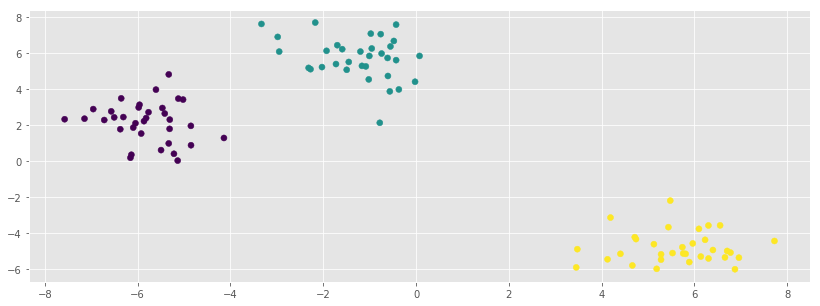

In [6]:
plt.scatter(X[:,0], X[:, 1], c=y)

Проверьте Вашу имплементацию на простых данных (без этого пункта ДЗ не считается выполненным).   
КОММЕНТАРИИ НЕ СТИРАТЬ!

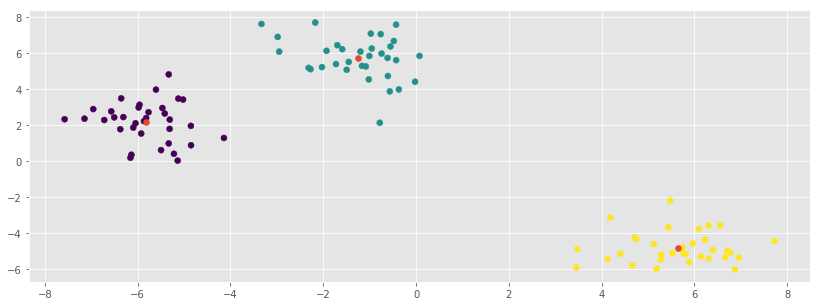

In [7]:
## Работоспособность MyKmeans
my_clf = MyKmeans(k=3)
my_clf.fit(X)
plt.scatter(X[:,0], X[:, 1], c=my_clf.labels)
plt.scatter(my_clf.centroids[:,0], my_clf.centroids[:,1])

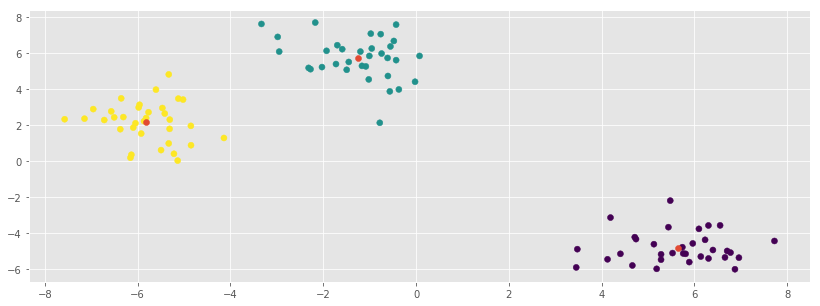

In [8]:
## Работоспособность MyKmeans++
my_clf = MyKmeans(k=3, init='k-means')
my_clf.fit(X)
plt.scatter(X[:,0], X[:, 1], c=my_clf.labels)
plt.scatter(my_clf.centroids[:,0], my_clf.centroids[:,1])

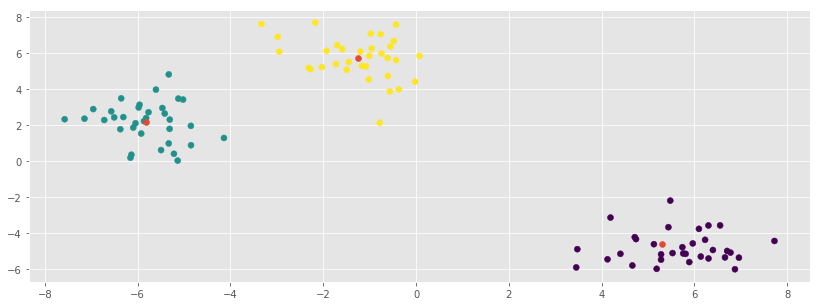

In [9]:
## Работоспособность MyKmeans с MiniBatchMyKmeans
my_clf = MiniBatchKMeans(k=3)
my_clf.fit(X)
plt.scatter(X[:,0], X[:, 1], c=my_clf.labels)
plt.scatter(my_clf.centroids[:,0], my_clf.centroids[:,1])

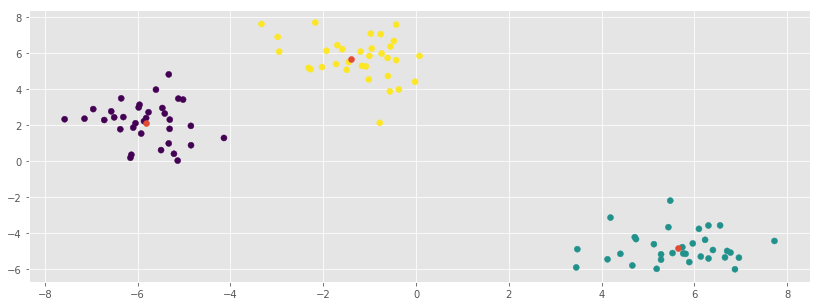

In [10]:
## Работоспособность MyKmeans++ с MiniBatchMyKmeans
my_clf = MiniBatchKMeans(k=3, init='k-means')
my_clf.fit(X)
plt.scatter(X[:,0], X[:, 1], c=my_clf.labels)
plt.scatter(my_clf.centroids[:,0], my_clf.centroids[:,1])

In [11]:
from time import time
from sklearn.cluster import KMeans

In [12]:
def get_time(clf, n_samples):
    num_iterations = 100

    t = 0
    for _ in range(num_iterations):
        X, y = make_blobs(n_samples=n_samples, n_features=2, centers=3, cluster_std=1, 
               center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
        start = time()
        clf.fit(X)
        t += time() - start
    return t / num_iterations

samples = list(range(10000, 50001, 5000))

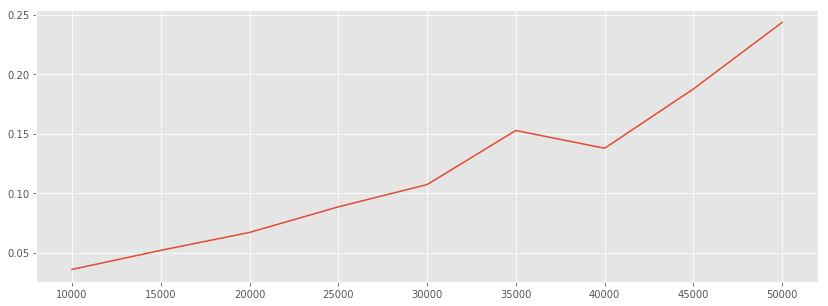

In [13]:
## Время выполнения алгоритма Kmeans из sklearn
times = []
for sample in samples:
    clf = KMeans(n_clusters=3)
    times.append(get_time(clf, sample))

plt.plot(samples, times)
plt.show()

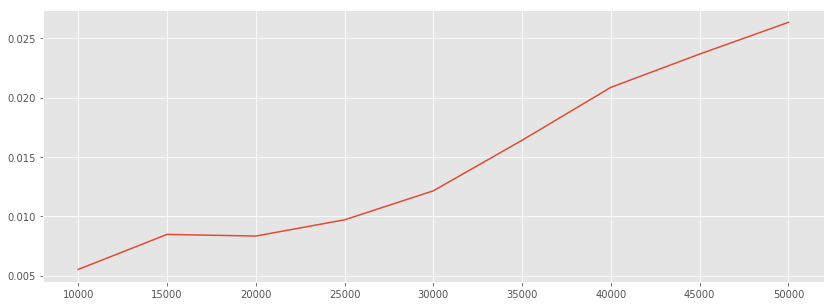

In [14]:
## Время выполнения алгоритма MyKmeans
times = []
for sample in samples:
    clf = MyKmeans(k=3)
    times.append(get_time(clf, sample))

plt.plot(samples, times)
plt.show()

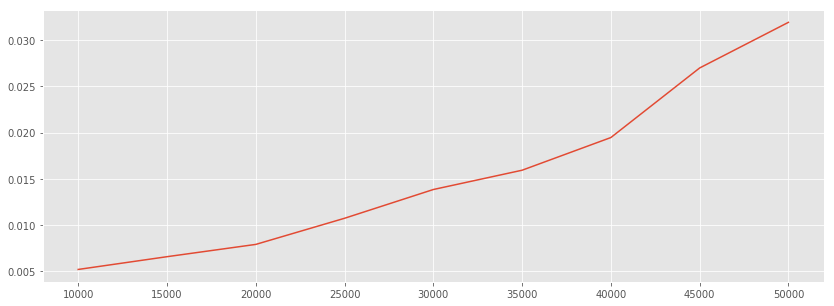

In [15]:
## Время выполнения алгоритма MyKmeans++
times = []
for sample in samples:
    clf = MyKmeans(k=3, init='k-means')
    times.append(get_time(clf, sample))

plt.plot(samples, times)
plt.show()

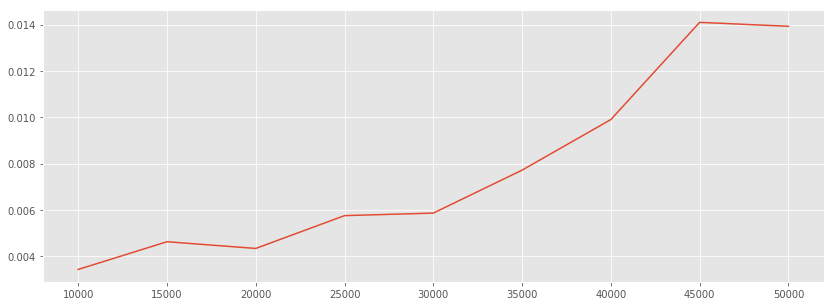

In [16]:
## Время выполнения алгоритма MyKmeans с MiniBatchMyKmeans
times = []
for sample in samples:
    clf = MiniBatchKMeans(k=3, batch_size=200)
    times.append(get_time(clf, sample))

plt.plot(samples, times)
plt.show()

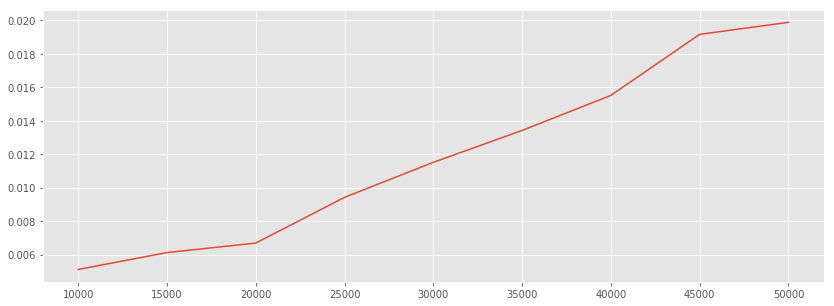

In [17]:
## Время выполнения алгоритма  MyKmeans++ с MiniBatchMyKmeans
times = []
for sample in samples:
    clf = MiniBatchKMeans(k=3, init='k-means', batch_size=200)
    times.append(get_time(clf, sample))

plt.plot(samples, times)
plt.show()

# Применение K-means на реальных данных

Загрузите [данные](https://github.com/brenden17/sklearnlab/blob/master/facebook/snsdata.csv) в которых содержится описание интересов профилей учеников старшей школы США.  (без этого пункта задание не считается выполненным).   
ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [18]:
df_sns = pd.read_csv('snsdata.csv', sep=',')
df_sns.head()

,gradyear,gender,age,friends,basketball,football,soccer,softball,volleyball,swimming,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,2006,M,18.982,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2006,F,18.801,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2006,M,18.335,69,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2006,F,18.875,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2006,NaN,18.995,10,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1


In [19]:
df_sns = df_sns.drop(['gradyear', 'gender', 'age', 'friends'], axis='columns')
df_sns = (df_sns - df_sns.mean(axis=0)) / df_sns.std(axis=0)
df_sns.head()

,basketball,football,soccer,softball,volleyball,swimming,cheerleading,baseball,tennis,sports,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,-0.332212,-0.357691,-0.24287,-0.217924,-0.223666,-0.259966,-0.207324,-0.201127,-0.168936,-0.297118,...,-0.050936,-0.369909,-0.487306,-0.314193,-0.201473,-0.183029,-0.294788,-0.261526,-0.220399,-0.174905
1,-0.332212,1.060031,-0.24287,-0.217924,-0.223666,-0.259966,-0.207324,-0.201127,-0.168936,-0.297118,...,-0.050936,1.067374,-0.487306,-0.314193,-0.201473,-0.183029,-0.294788,-0.261526,-0.220399,-0.174905
2,-0.332212,1.060031,-0.24287,-0.217924,-0.223666,-0.259966,-0.207324,-0.201127,-0.168936,-0.297118,...,-0.050936,-0.369909,-0.487306,-0.314193,-0.201473,-0.183029,-0.294788,2.027874,-0.220399,-0.174905
3,-0.332212,-0.357691,-0.24287,-0.217924,-0.223666,-0.259966,-0.207324,-0.201127,-0.168936,-0.297118,...,-0.050936,-0.369909,-0.487306,-0.314193,-0.201473,-0.183029,-0.294788,-0.261526,-0.220399,-0.174905
4,-0.332212,-0.357691,-0.24287,-0.217924,-0.223666,-0.259966,-0.207324,-0.201127,-0.168936,-0.297118,...,-0.050936,-0.369909,2.273635,-0.314193,-0.201473,-0.183029,-0.294788,-0.261526,2.285084,2.719271


Данные устроены так: 
* Год выпуска
* Пол
* Возраст
* Количество друзей
* 36 ключевых слов, которые встречаются в профилe facebook (интересы, сообщества, встречи)

* Удалите все признаки кроме 36 ключевых слов.
* Нормализуйте данные - из каждого столбца вычтите его среднее значение и поделите на стандартное отклонение.
* Используйте метод k-means чтобы выделить 9 кластеров
* Попробуйте проинтерпретировать каждый кластер проанализировав полученные центройды (Некоторые кластеры могут быть очень большие и очень маленькие - плохо интерпретируются)   
КОММЕНТАРИИ НЕ СТИРАТЬ!

In [20]:
## MyKMeans
clf = MyKmeans(k=9)

start = time()
clf.fit(df_sns.values)

print("time:", time() - start)
print("Clasters sizes:", *np.bincount(clf.labels), "\n")

df_sns.loc[:, 'labels'] = clf.labels

clusters = df_sns.groupby('labels').mean()
sizes = df_sns.groupby('labels').count().values
for i in range(9):
    print(clusters.loc[i].sort_values(ascending=False).head(5))
    print("Size:", sizes[i][0], "\n")

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in sqrt


time: 0.4996614456176758
Clasters sizes: 850 604 2757 19604 3259 927 479 1065 455 

hollister      4.161361
abercrombie    3.987458
shopping       0.790847
mall           0.582080
clothes        0.564476
Name: 0, dtype: float64
Size: 850 

sexy    4.882531
cute    0.885106
hot     0.409579
hair    0.347982
sex     0.304338
Name: 1, dtype: float64
Size: 604 

football      1.284748
basketball    1.243572
baseball      1.081549
sports        1.021823
softball      0.907913
Name: 2, dtype: float64
Size: 2757 

blonde   -0.029295
tennis   -0.056646
death    -0.077360
jesus    -0.077865
bible    -0.082311
Name: 3, dtype: float64
Size: 19604 

shopping    1.254484
swimming    1.036275
hot         0.696373
mall        0.666046
clothes     0.531079
Name: 4, dtype: float64
Size: 3259 

kissed    3.126791
drugs     2.906596
hair      2.623564
sex       2.136257
drunk     1.841827
Name: 5, dtype: float64
Size: 927 

marching    5.785146
band        4.583876
music       0.609415
rock        0.2302

In [21]:
## MyKMeans++
clf = MyKmeans(k=9, init='k-means')

start = time()
clf.fit(df_sns.values)
print("time:", time() - start, "\n")

print("Clasters sizes:", *np.bincount(clf.labels), "\n")

df_sns.loc[:, 'labels'] = clf.labels

clusters = df_sns.groupby('labels').mean()
sizes = df_sns.groupby('labels').count().values
for i in range(9):
    print(clusters.loc[i].sort_values(ascending=False).head(5))
    print("Size:", sizes[i][0], "\n")

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in sqrt
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in less


time: 1.2237262725830078 

Clasters sizes: 1684 843 2570 17117 996 1102 780 2290 2618 

kissed      1.630139
marching    1.598123
drugs       1.521385
band        1.497569
hair        1.285261
Name: 0, dtype: float64
Size: 1684 

hollister      4.183906
abercrombie    4.009359
shopping       0.778535
mall           0.583165
clothes        0.564243
Name: 1, dtype: float64
Size: 843 

football      1.282895
basketball    1.279413
baseball      1.136844
sports        1.067408
softball      0.953010
Name: 2, dtype: float64
Size: 2570 

blonde     -0.031174
tennis     -0.051971
bible      -0.081122
jesus      -0.081775
marching   -0.094208
Name: 3, dtype: float64
Size: 17117 

dress       3.941744
cute        0.618625
dance       0.573038
shopping    0.545275
mall        0.490152
Name: 4, dtype: float64
Size: 996 

cheerleading    2.848457
sexy            2.498592
cute            0.410726
hot             0.247126
shopping        0.187897
Name: 5, dtype: float64
Size: 1102 

dance       4.08

In [22]:
## MyKMeans с MiniBatchMyKMeans
clf = MiniBatchKMeans(k=9, batch_size=200)

start = time()
clf.fit(df_sns.values)
print("time:", time() - start)

print("Clasters sizes:", *np.bincount(clf.labels), "\n")

df_sns.loc[:, 'labels'] = clf.labels

clusters = df_sns.groupby('labels').mean()
sizes = df_sns.groupby('labels').count().values
for i in range(9):
    print(clusters.loc[i].sort_values(ascending=False).head(5))
    print("Size:", sizes[i][0], "\n")

time: 0.6522574424743652
Clasters sizes: 17652 346 1827 834 1389 5751 496 1242 463 

blonde         -0.028915
cheerleading   -0.032084
sexy           -0.046060
tennis         -0.048393
soccer         -0.063016
Name: 0, dtype: float64
Size: 17652 

volleyball    7.015965
basketball    0.598008
sports        0.359348
shopping      0.342572
softball      0.340804
Name: 1, dtype: float64
Size: 346 

dress    2.256994
music    0.796294
rock     0.677314
dance    0.227032
cute     0.212217
Name: 2, dtype: float64
Size: 1827 

kissed    3.345038
drugs     3.212044
hair      2.680560
sex       2.383517
drunk     2.011704
Name: 3, dtype: float64
Size: 834 

baseball      2.217880
football      2.130723
basketball    1.453536
sports        1.414554
soccer        0.637017
Name: 4, dtype: float64
Size: 1389 

death       0.687514
shopping    0.589514
swimming    0.507218
dance       0.500132
hot         0.348358
Name: 5, dtype: float64
Size: 5751 

bible     4.063079
god       3.424008
jesus     3

In [23]:
## MyKMeans++ с MiniBatchMyKMeans
clf = MiniBatchKMeans(k=9, init='k-means', batch_size=200)

start = time()
clf.fit(df_sns.values)
print("time:", time() - start)

print("Clasters sizes:", *np.bincount(clf.labels), "\n")

df_sns.loc[:, 'labels'] = clf.labels

clusters = df_sns.groupby('labels').mean()
sizes = df_sns.groupby('labels').count().values
for i in range(9):
    print(clusters.loc[i].sort_values(ascending=False).head(5))
    print("Size:", sizes[i][0], "\n")

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in sqrt
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in less


time: 0.5555152893066406
Clasters sizes: 17453 641 1772 903 1395 5555 523 1254 504 

blonde         -0.029372
cheerleading   -0.033205
sexy           -0.046358
tennis         -0.048127
soccer         -0.064588
Name: 0, dtype: float64
Size: 17453 

volleyball    5.107838
basketball    0.489784
sports        0.216190
shopping      0.206160
football      0.197454
Name: 1, dtype: float64
Size: 641 

dress    2.307087
music    0.802345
rock     0.654768
dance    0.227954
cute     0.217227
Name: 2, dtype: float64
Size: 1772 

kissed    3.156575
drugs     3.091059
hair      2.608712
sex       2.291629
drunk     2.132480
Name: 3, dtype: float64
Size: 903 

baseball      2.256939
football      2.154574
basketball    1.435166
sports        1.414801
soccer        0.630888
Name: 4, dtype: float64
Size: 1395 

death       0.688853
shopping    0.577557
swimming    0.487976
dance       0.486707
cute        0.335043
Name: 5, dtype: float64
Size: 5555 

bible     3.847940
god       3.492702
jesus     3

## Вывод
В принципе кластеры хорошо интерпретируются на всех алгоритмах. Отчётливо видны кластеры: спортсмены, верующие, музыканты и т.д.

kmeans++ Даёт лучшую начальную инициализацию, но просаживает алгоритм по скорости, потому что приходится просчитывать много раз расстояния для всей выборки. MiniBatchKMenans наоборот даёт прирост в скорости, но занижает качество кластеризации, так как на каждой итерации алгоритма мы работаем только с частью выборки. Все алгоритмы хороши, и использовать их нужно по ситуации. Однако, kmeans++ нужно использовать (как мне кажется) практически всегда, так как он в разы лучше, чем рандомная инициализация, что покрывает его минус в незначительной потери в скорости работы. MiniBatchKmeans - палка о двух концах, исопльзовать осторожно.